**Задание**

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Пункт 1 задания**

In [2]:
# Возьмем для анализа следующие 2 ряда
airlines_passengers = pd.read_csv("/content/international-airline-passengers.csv")
female_births = pd.read_csv("/content/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Daily total female births in California": female_births["Count"]
}

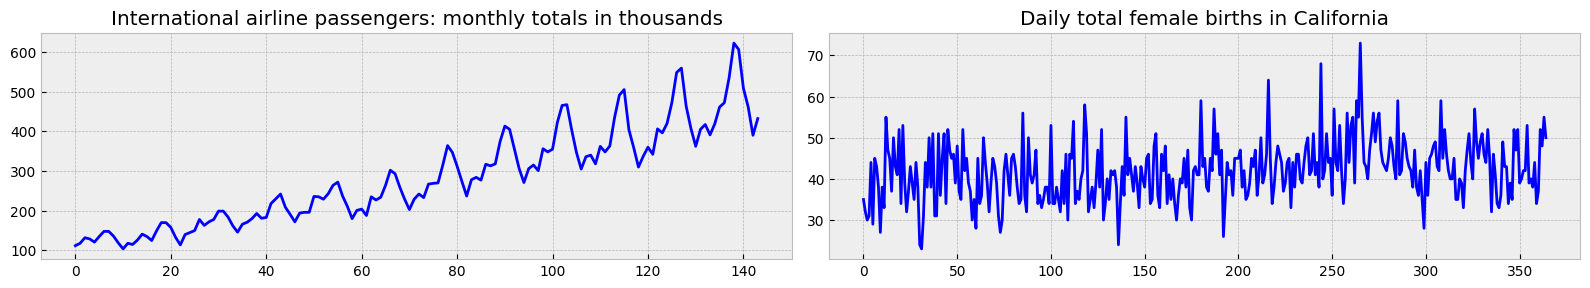

In [4]:
#Отобразим выбранные ВР

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

Временной ряд "International airline passengers" нестационарный, поскольку:
1. Визуально не похож на шум
2. Имеет восходящий тренд
3. Имеет сезонность
4. Дисперсия монотонно возрастает
5. Из ДЗ №1 p-value по тесту Дики-Фуллера было > 0,05.

Временной ряд "Daily total female births in California" стационарный, поскольку:
1. Визуально похож на шум
2. Отсутствуют тренд и сезонность
3. Из ДЗ №1 p-value по тесту Дики-Фуллера было < 0,05.

Подробный анализ ВР на предмет их стационарности проведен в ДЗ №1:

https://github.com/Pavel-Bonarev/HW_Time_series/blob/main/1_HW_Bonarev_Stat_time_series.ipynb

**Пункт 2 задания**

**Блок А**

В рамках настоящего ДЗ для обоих рядов будем использовать следующие модели из класса MA:
1. Скользящее среднее
2. Взвешенное скользящее среднее
3. Экпоненциальное скользящее среднее (простое/двойное/тройное (метод Хольта-Винтерса))

**Блок Б**

На основе задач из Блока А для каждого ВР выберем наиболее подходящий метод, создадим и обучим модель для предсказания значений ВР, оценим её качество

**Пункт 2.1.(А) - Применение скользящего среднего (MA)**

In [5]:
"""
Функция для нахождения скользящего среднего
"""

def moving_average(series, n):
    if not isinstance(series, pd.Series): #Проверка входного ВР на соответствие типу данных pd.Series
        series = pd.Series(series)
    return series.rolling(n).mean()

#Метод rolling позволяет проходить по ВР окном размера n

In [6]:
"""
Функция для предсказания n следующих измерений
"""

def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series._append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

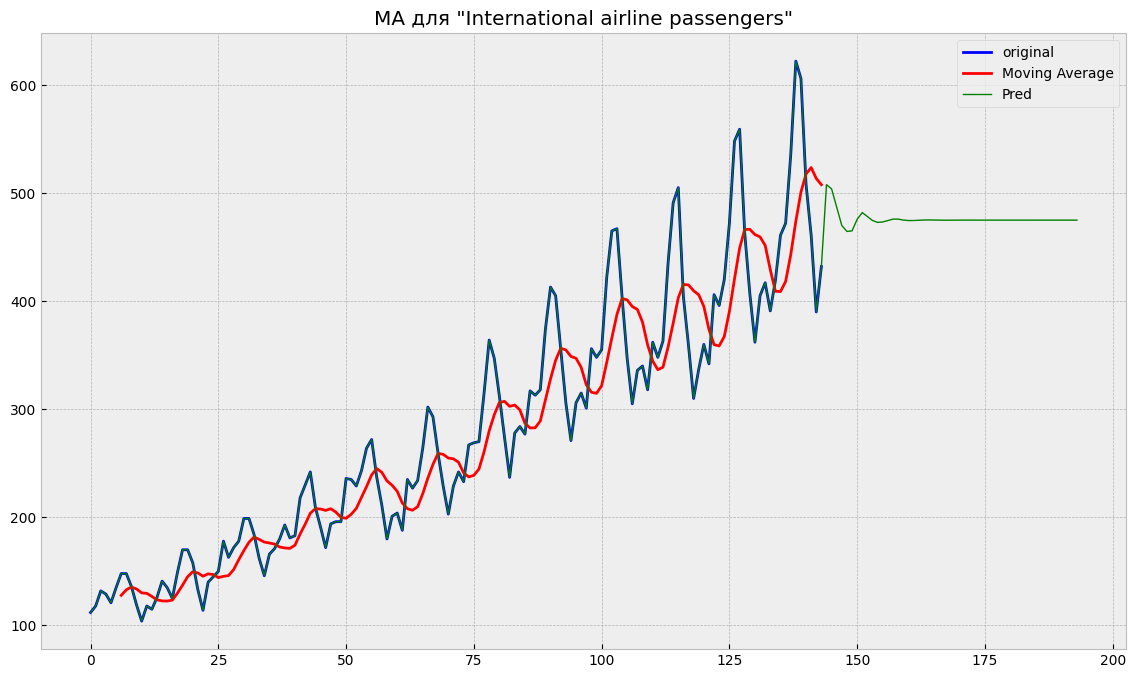

In [7]:
ma_1 = moving_average(airlines_passengers["Count"], 7)
series_pred_ma_1 = predict(airlines_passengers["Count"], 7, 50)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(ma_1, color='red', linewidth='2', label='Moving Average')
    plt.plot(series_pred_ma_1, color='green', linewidth='1', label='Pred')
    plt.legend()
    plt.title('MA для "International airline passengers"')

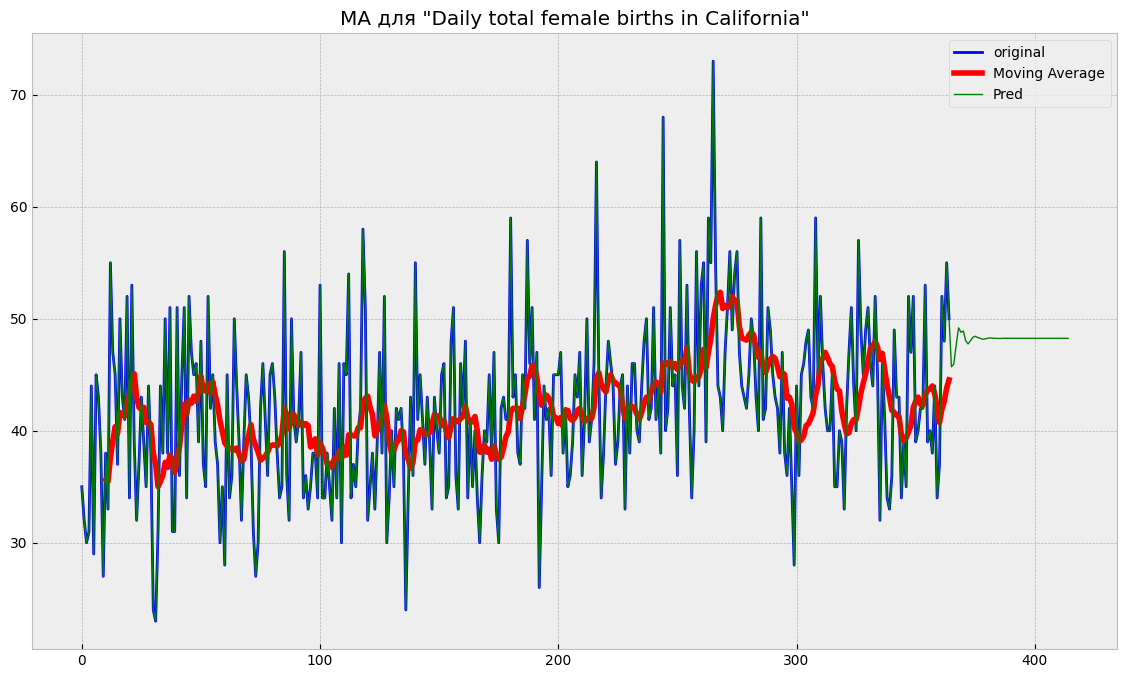

In [8]:
ma_2 = moving_average(female_births["Count"], 11)
series_pred_ma_2 = predict(female_births["Count"], 7, 50)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ma_2, color='red', linewidth='4', label='Moving Average')
    plt.plot(series_pred_ma_2, color='green', linewidth='1', label='Pred')
    plt.legend()
    plt.title('MA для "Daily total female births in California"')

**Вывод**

Простое скользящее среднее усредняет временной ряд, но не учитывает компоненты ВР (тренд, сезонность, разброс), в связи с чем для обеих ВР метод простого MA для прогноза измерений является малоэффективным.

**Пункт 2.2.(А) - Применение взвешенного скользящего среднего (WMA)**

In [9]:
#В качестве весов возьмем последовательность Фибоначчи

weights_1 = np.array([1,1,2,3,5,8,13])
weights_2 = np.array([1,1,2,3,5,8,13,21,34,55,89])

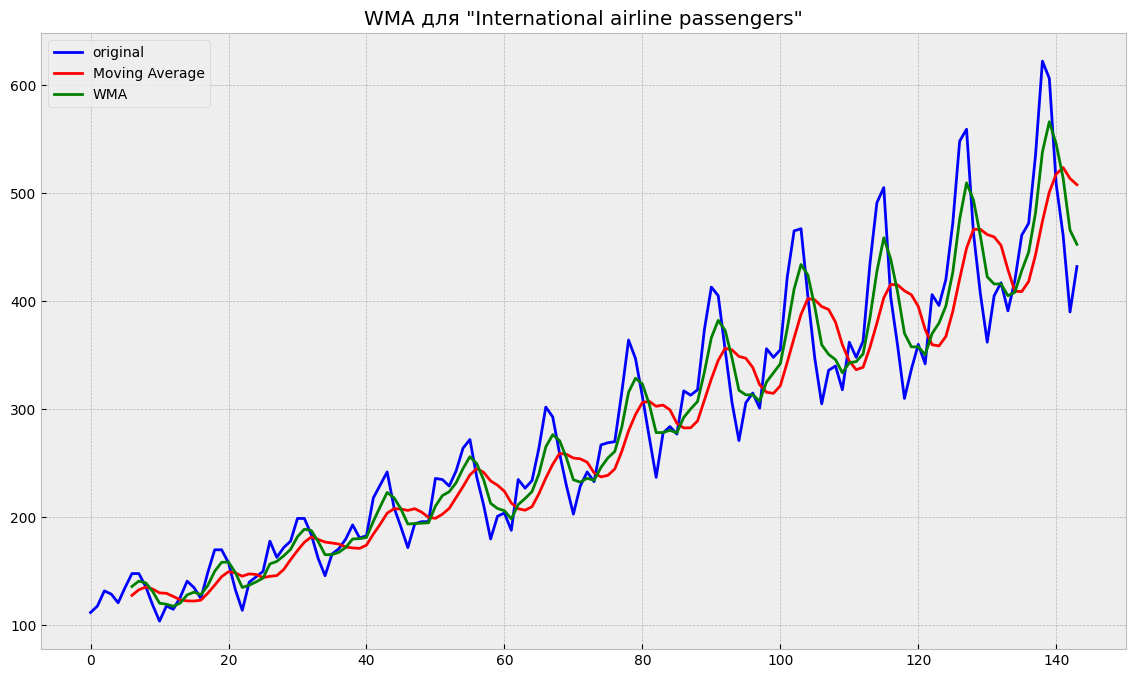

In [10]:
wma_1 = airlines_passengers["Count"].rolling(7).apply(lambda s: (s * weights_1).sum() / weights_1.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(ma_1, color='red', linewidth='2', label='Moving Average')
    plt.plot(wma_1, color='green', linewidth='2', label='WMA')
    plt.legend()
    plt.title('WMA для "International airline passengers"')

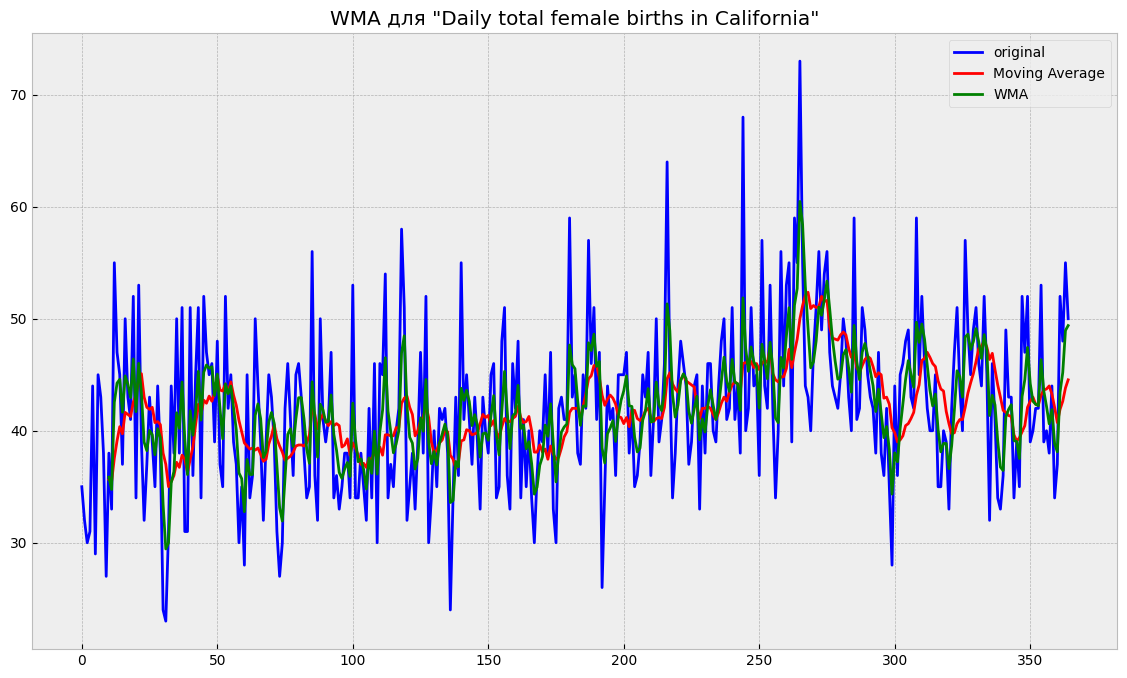

In [11]:
wma_2 = female_births["Count"].rolling(11).apply(lambda s: (s * weights_2).sum() / weights_2.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ma_2, color='red', linewidth='2', label='Moving Average')
    plt.plot(wma_2, color='green', linewidth='2', label='WMA')
    plt.legend()
    plt.title('WMA для "Daily total female births in California"')

**Вывод**

Взвешенное скользящее среднее уже точнее описывает временной ряд (опираясь больше на недавние значения, чем на более поздние), но все также не учитывает компоненты ВР (тренд, сезонность, разброс).

**Пункт 2.3.(А) - Применение экспоненциального сглаживания (EMA)**

**Простое экспоненциальное сглаживание**

In [12]:
'''
Функция, которая предсказывает 5 наблюдений ряда на основе EMA
'''

def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return series._append(pd.Series(predictions), ignore_index=True), pd.Series(result)

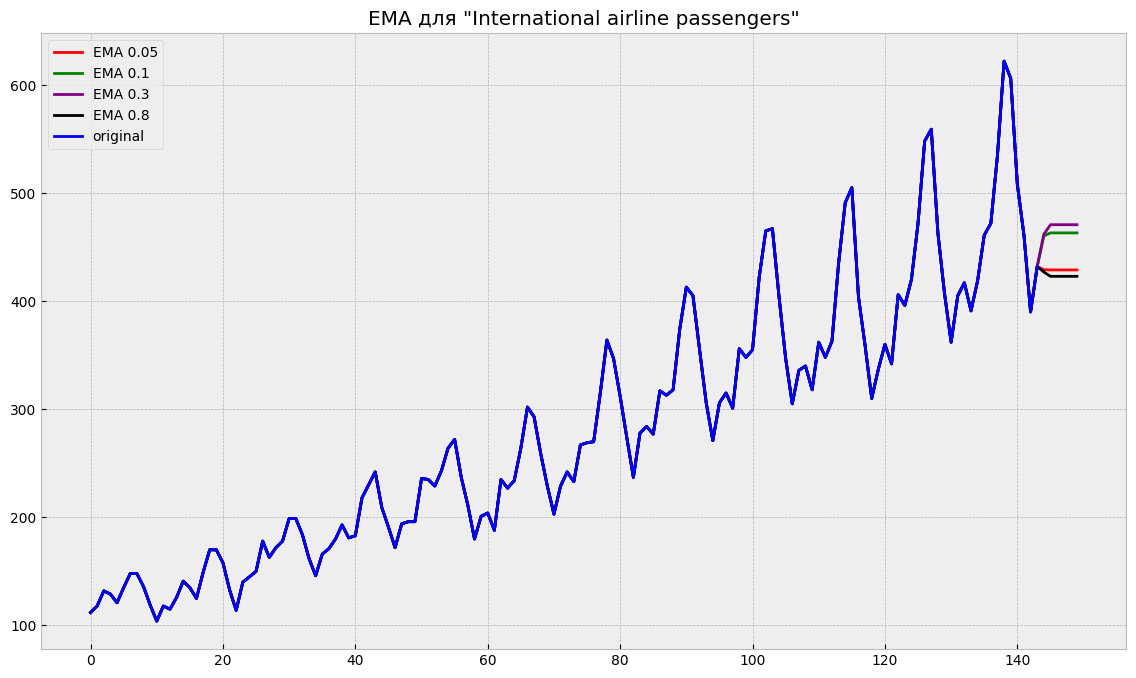

In [13]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ema_1, _ = exponential_moving_average(airlines_passengers["Count"], alphas[i], 5)
        plt.plot(ema_1, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.legend()
    plt.title('EMA для "International airline passengers"')

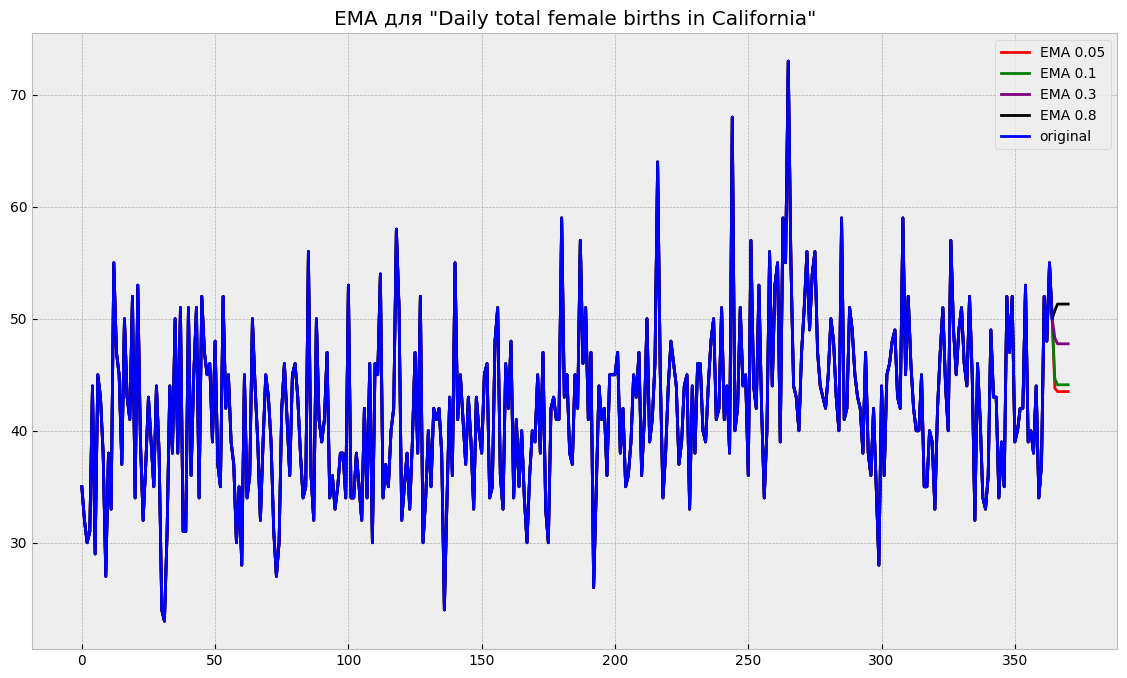

In [14]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ema_2, _ = exponential_moving_average(female_births["Count"], alphas[i], 5)
        plt.plot(ema_2, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.legend()
    plt.title('EMA для "Daily total female births in California"')

**Вывод**

Чем меньше  𝛼 , тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд.

Применение экспоненциального сглаживания проще, поскольку достаточно подобрать лишь подходящее значение для  𝛼.

Если рассматривать метод для целей прогнозирования, то для средне- и долгосрочного прогнозирования ВР метод не покажет хороших точных результатов.

**Двойное экспоненциальное сглаживание**

In [15]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [16]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series._append(pd.Series(preds), ignore_index=True), pd.Series(result)

In [17]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']

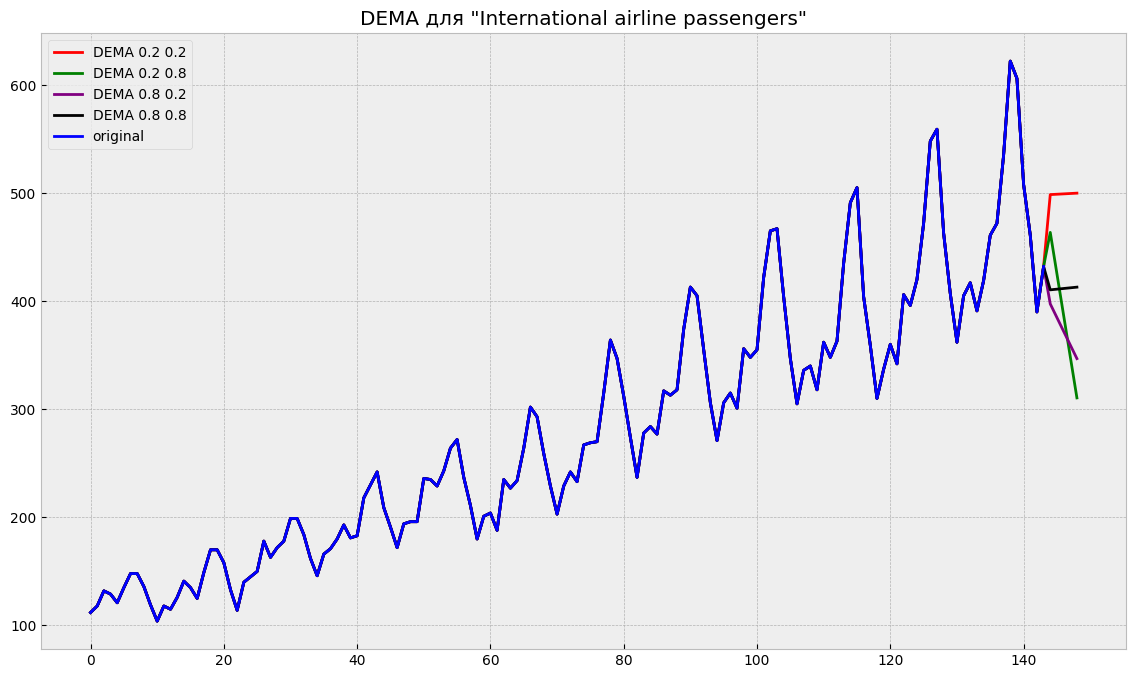

In [18]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        dema_1, _ = double_ema_with_preds(airlines_passengers["Count"], alphas[i], bettas[i], 5)
        plt.plot(dema_1, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.legend()
    plt.title('DEMA для "International airline passengers"')

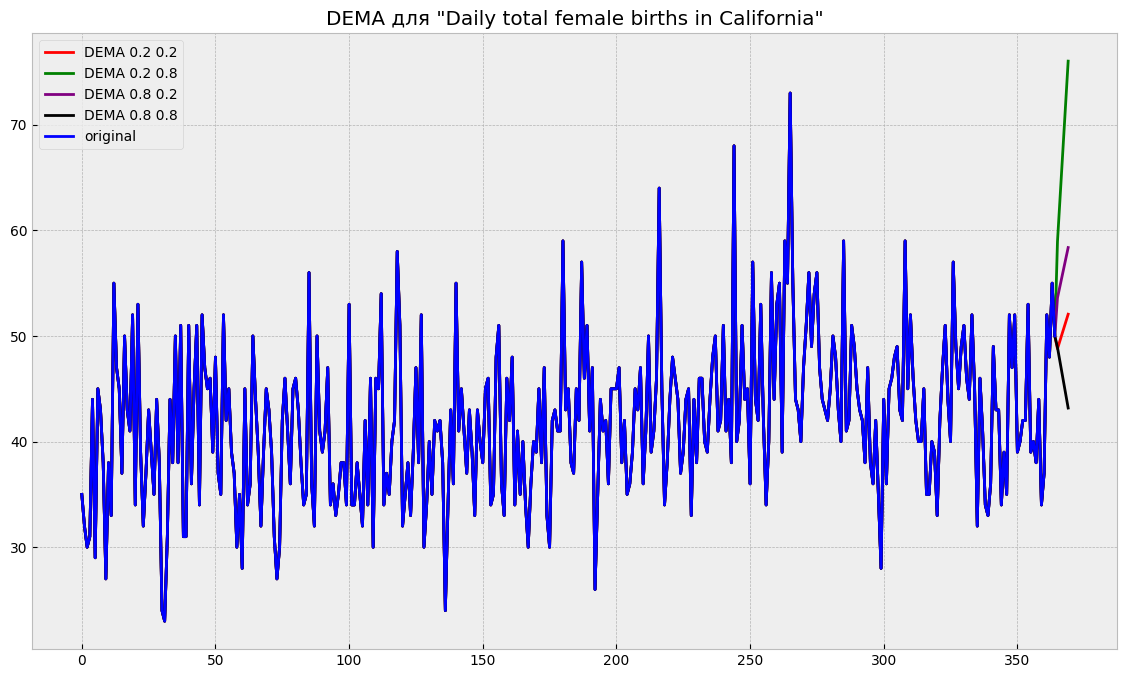

In [19]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        dema_2, _ = double_ema_with_preds(female_births["Count"], alphas[i], bettas[i], 5)
        plt.plot(dema_2, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.legend()
    plt.title('DEMA для "Daily total female births in California"')

**Вывод**

 𝛼  отвечает за сглаживание ряда вокруг тренда,  𝛽  - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

**Тройное экспоненциальное сглаживание / Модель Хольта-Винтерса**

In [20]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [21]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


In [22]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [23]:
alpha, beta, gamma = 0.3, 0.4, 0.3
n_periods2_pred = 30

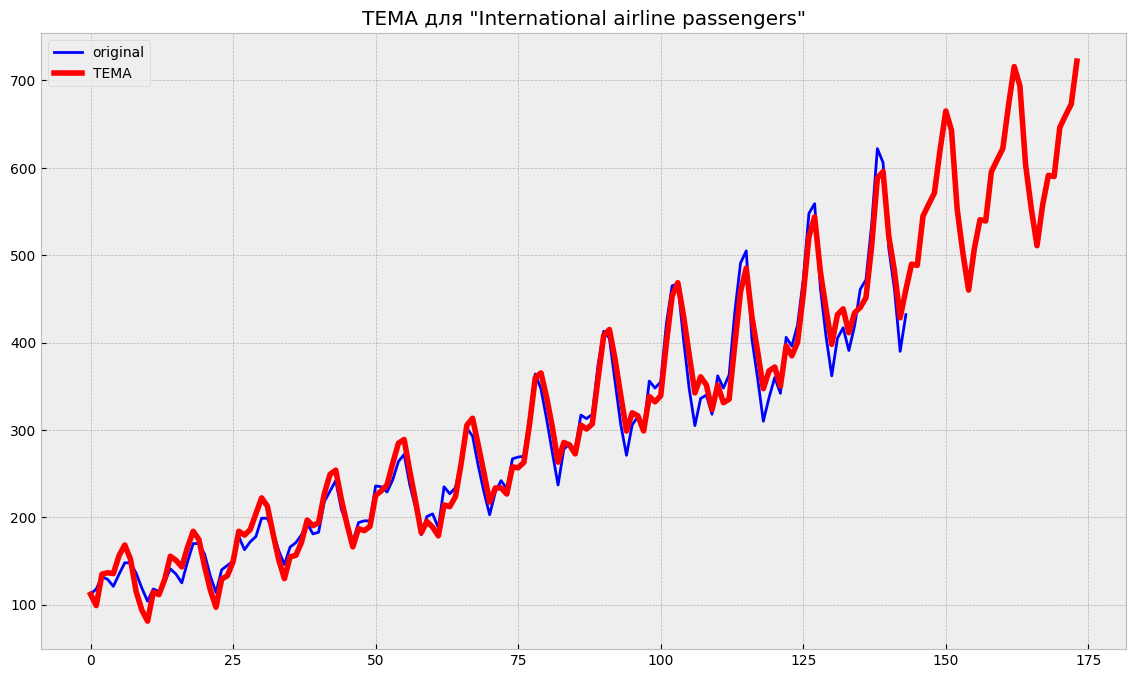

In [24]:
tema_1 = triple_exponential_smoothing(airlines_passengers["Count"], 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(tema_1, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()
    plt.title('TEMA для "International airline passengers"')

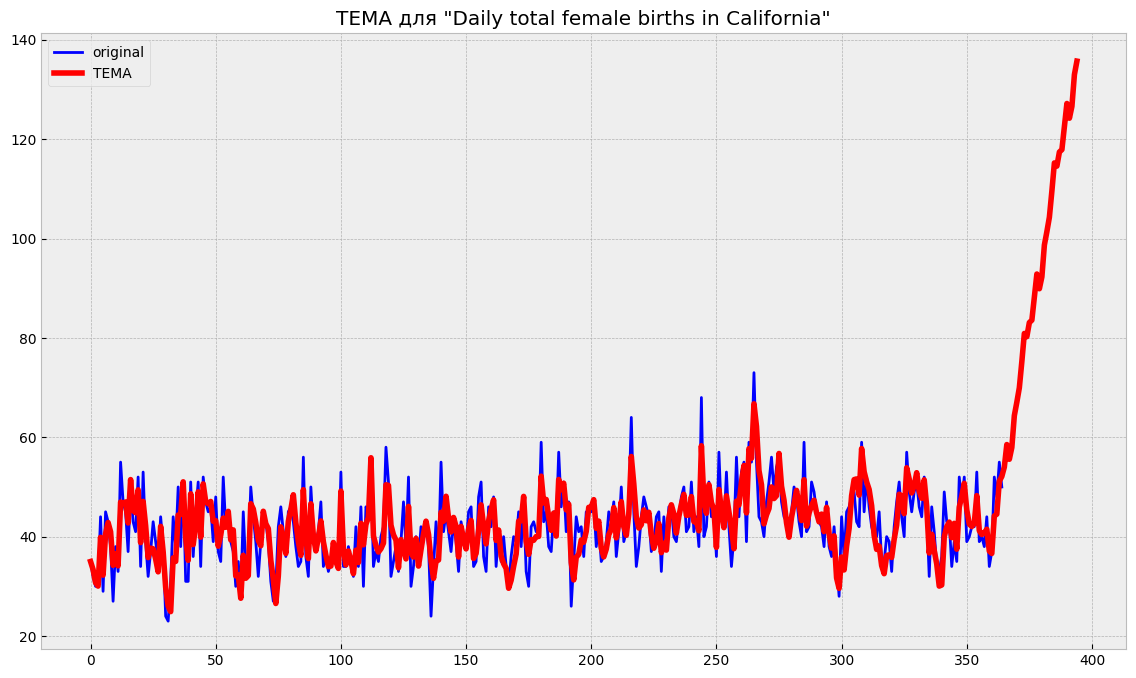

In [25]:
tema_2 = triple_exponential_smoothing(female_births["Count"], 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(tema_2, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()
    plt.title('TEMA для "Daily total female births in California"')

**Вывод**

Метод Хольта-Винтерса используется для прогноза временных рядов, которые содержат трендовую и сезонную составляющую.

Временной ряд "Daily total female births in California" не содержит указанных свойств временного ряда. В связи с чем для прогноза его будущих измерений воспользуемся методом DEMA.

Как видно из графика, временной ряд "International airline passengers" хорошо описывается методом Хольта-Винтерса, который учитывает его компоненты для будущих измерений.

**Пункт 2.1(Б). Прогноз для "International airline passengers"**

In [26]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [27]:
ap_ts_model_tema_1 = airlines_passengers["Count"]

train_length = round(len(ap_ts_model_tema_1)*.70)

In [28]:
from sklearn.model_selection import TimeSeriesSplit

train, val = ap_ts_model_tema_1[:train_length], ap_ts_model_tema_1[train_length:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(ap_ts_model_tema_1):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.2491208619682703e-07
        x: [ 4.306e-02  2.606e-01  9.711e-01]
      nit: 42
      jac: [ 2.753e-05 -1.584e-05  3.377e-05]
     nfev: 256
     njev: 64
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


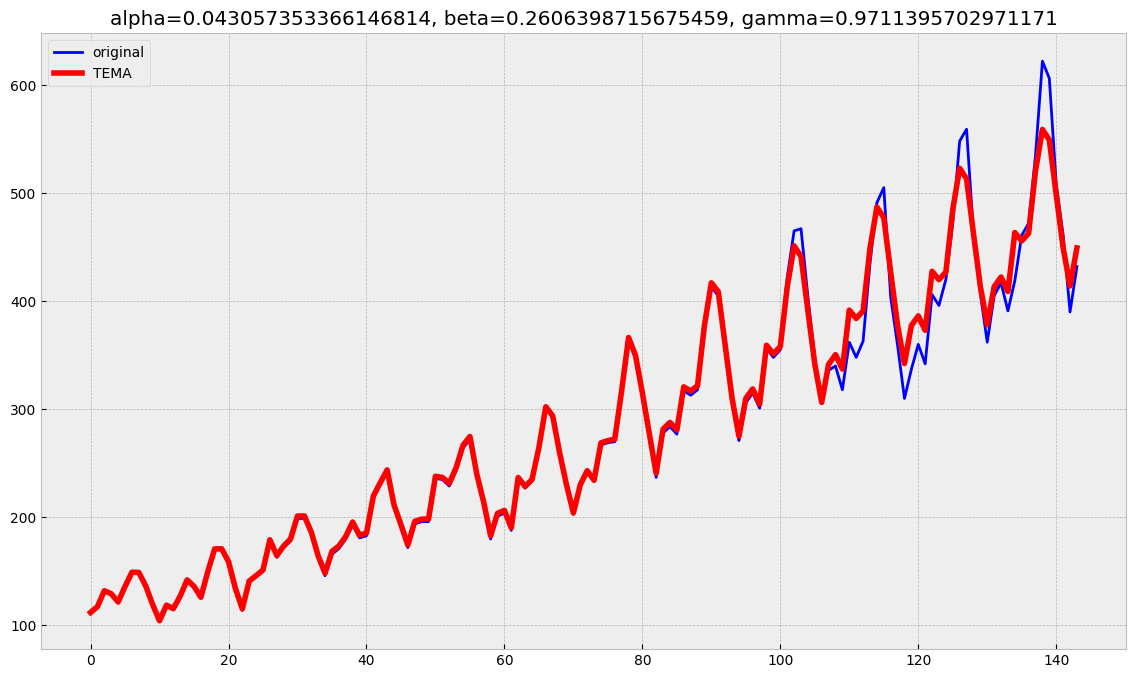

In [29]:
# проверим результат модели на валидационных данных

tema_1 = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(ap_ts_model_tema_1, color='blue',label='original')
    plt.plot(tema_1, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [30]:
from sklearn.metrics import r2_score
r2_score(y_pred=tema_1, y_true=ap_ts_model_tema_1)

0.9870395547857226

**Пункт 2.2(Б). Прогноз для "Daily total female births in California"**

In [31]:
def dema(series, alpha=0.8, beta=0.5, pred=None):
  """
  return list-type simple exponential smoothing of time-series,
  where alpha, beta is a float number and
  series is pandas' series data type
  period - integer number of periods to predict, default None
  """
  S = [series[0]]
  B = [(series[len(series)-1] - series[0])/len(series)]
  F = [S[0]+B[0]]

  for i in range(1, len(series)-1):
    S.append(alpha * series[i] + (1 - alpha) * (S[i-1]+B[i-1]))
    B.append(beta * (S[i]-S[i-1]) + (1 - beta)*B[i-1])
    F.append(S[i] + B[i])

  if pred is None:
    return F
  else:
    for _ in range(pred):
      S.append((alpha * S[-1]) + ((1 - alpha) * (S[-2]+B[-2])))
      B.append(beta * (S[-1]-S[-2]) + (1 - beta)*B[-2])
      F.append(S[-1] + B[-1])
    return F

In [32]:
fb_ts_model_dema_2 = female_births["Count"]

train_length = round(len(fb_ts_model_dema_2) - 12)

In [33]:
train, val = fb_ts_model_dema_2[:train_length], fb_ts_model_dema_2[train_length:]

In [34]:
def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(ap_ts_model_tema_1):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [36]:
opt = minimize(mse_cross_val, x0=[0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1)))

alpha_opt, beta_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 490.9395228731519
             x: [ 3.022e-01  0.000e+00]
           nit: 37
          nfev: 61
 final_simplex: (array([[ 3.022e-01,  0.000e+00],
                       [ 3.021e-01,  0.000e+00],
                       [ 3.021e-01,  0.000e+00]]), array([ 4.909e+02,  4.909e+02,  4.909e+02]))


In [37]:
a = dema(female_births["Count"], 3.022e-01, 0.000e+00, 12)
len(a)

376

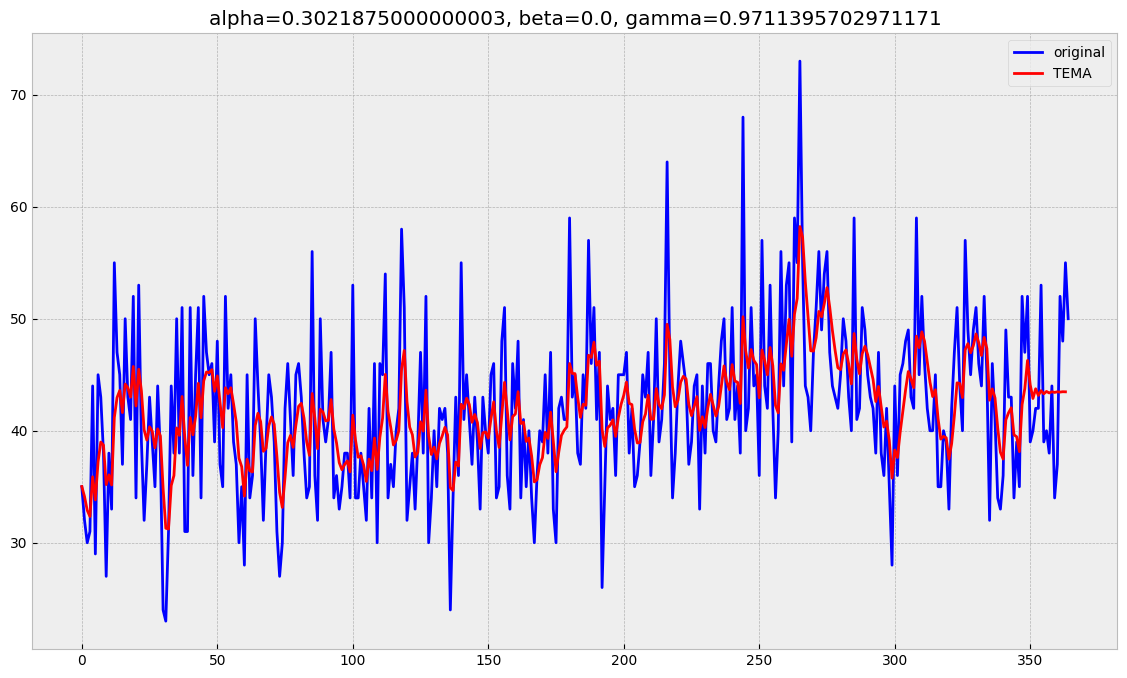

In [38]:
# проверим результат модели на валидационных данных

dema_2 = dema(train, 3.022e-01, 0.000e+00, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(fb_ts_model_dema_2, color='blue',label='original')
    plt.plot(dema_2, color='red', linewidth='2', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [39]:
from sklearn.metrics import r2_score
r2_score(y_pred=dema_2, y_true=fb_ts_model_dema_2[1:])

0.004648354466332383

**Пункт 3 задания**

**1. Относительно ВР "International airline passengers".**

Как уже было отмечено ранее, метод Хольта-Винтерса (тройное экспоненциальное сглаживание) используется для лучшего сглаживания/прогноза временных рядов, которые содержат трендовую и сезонную составляющую.

Поскольку ВР "International airline passengers" содержит указанные компоненты, то к нему был применен данный метод.

Метод для целей прогнозирования измерений показал хороший результат, сохранив "поведение" компонентов ВР для прогнозного интервала.

Более того, метрика качества MSE составила 0,98, что свидетельствует об очень хорошей предсказательной способности метода для выбранного ВР.


**2. Относительно ВР "Daily total female births in California".**

Временной ряд "Daily total female births in California" является стационарным, в нем отсутствует тренд/сезонность.

Вместе с тем, исходя из всех методов MA, наиболее подходящим для данного ВР (в целях его сглаживания/прогнозирования) является метод двойного экспоненциального сглаживания.

Как видно из пункта ДЗ 2.2(Б). Прогноз для "Daily total female births in California", при помощи выбранного метода ВР был достаточно хорошо сглажен.

Что касается его прогнозной функции, то метод фактически усреднил значения ВР для прогнозного интервала.

Если принимать во внимание, что выбранный временной ряд стационарный и фактически содержит только "белый шум", то использование в качестве прогноза будущих измерений его среднего значения, является разумным (т.к. "белый шум" случаен).